In [2]:
using Plots
using LinearAlgebra
using Jacobi
using Test
gr()
Plots.GRBackend()

Plots.GRBackend()

# AC quad element with added more supplements basis 

In [3]:
function BilinearMap(coord_E, xhat, yhat)
    """ 
    This function maps [xhat,yhat] in Ehat=[-1,1]^2 
    to (x,y) in E.
    Written based on eq. (3.3), (3.4) of AC paper 2016
    Input:
    ------
    coord_E: coordinates of quadrilateral E .
    coord_E is 4x2 array
    coord_E = [[x1,y1],
               [x2,y2],
               [x3,y3],
               [x4,y4]] with vertices numbering
    3----4
    |    |
    1----2
    [xhat, yhat] in Ehat
    Output:
    ------
    [x;y]: mapped vector in E.
    DF_E: Jacobian matrix
    J_E: det(DF_E)
    later we transform vector vhat to v by eq. (3.4)
    v(x) = P_E(vhat)(x) = (DF_E/J_E)*vhat(xhat)
    """
    m = length(xhat)
    P = 0.25 * [(1 .- xhat).*(1 .- yhat) (1 .+ xhat).*(1 .- yhat) (1 .- xhat).*(1 .+ yhat) (1 .+ xhat).*(1 .+ yhat)]
    P_E = P * coord_E
    # x=F_E(xhat)
    X = P_E
    x = X[:, 1]
    y = X[:, 2]
    # gradient of P, 1st row = dP/dxhat, 2nd row=dP/dyhat
    # GradP_(2m x 4)
    GradP = 0.25 * [-(1 .- yhat) (1 .- yhat) -(1 .+ yhat) (1 .+ yhat);
                    -(1 .- xhat) -(1 .+ xhat) (1 .- xhat) (1 .+ xhat)]

    # JT= [[dx/dxhat, dy/dxhat],
    #      [dx/dyhat, dy/dyhat]] (2m x 2)
    JT = GradP * coord_E
    dxdxhat = JT[1:m,1]
    dydxhat = JT[1:m,2]
    dxdyhat = JT[m+1:2*m,1]
    dydyhat = JT[m+1:2*m,2]
    J_E = dxdxhat .* dydyhat .- dydxhat .* dxdyhat
    
    DF_E = [dxdxhat dxdyhat;dydxhat dydyhat]
    
    return x, y, DF_E, J_E
end


function PrimeBasis(coord_E, xhat, yhat)

    # original supplements in AC paper
    sghat1 = [(1 .- xhat.^2) (2*xhat .* yhat)]
    sghat2 = [(-2*xhat .* yhat) (yhat.^2 .- 1)]
    # New supplements
    sghat3 = [(2*yhat .* (1 .+ xhat .+ xhat.^3)) -((1 .+ 3*xhat.^2).* yhat.^2)]
    sghat4 = [((1 .+ 3*yhat.^2).* xhat.^2) -(2*xhat .* (1 .+ yhat .+ yhat.^3))]
    
    # (x,y) are in E
    x, y, DF_E, J_E = BilinearMap(coord_E, xhat, yhat)

    m = length(xhat)
    # we have 8 basis including sg1 and sg2
    P = zeros(2*m,10)
    P[1:m,1] = ones(m)
    P[1:m,2] = x
    P[1:m,3] = y
    P[m+1:2*m,4] = ones(m)
    P[m+1:2*m,5] = x
    P[m+1:2*m,6] = y
    for i=1:m
    P[i,7] = dot(DF_E[i,:], sghat1[i,:]) / J_E[i]
    P[i+m,7] = dot(DF_E[i+m,:], sghat1[i,:]) / J_E[i]
    end
    
    for i=1:m
    P[i,8] = dot(DF_E[i,:], sghat2[i,:]) / J_E[i]
    P[i+m,8] = dot(DF_E[i+m,:], sghat2[i,:]) / J_E[i]
    end
    
    for i=1:m
    P[i,9] = dot(DF_E[i,:], sghat3[i,:]) / J_E[i]
    P[i+m,9] = dot(DF_E[i+m,:], sghat3[i,:]) / J_E[i]
    end
    
    for i=1:m
    P[i,10] = dot(DF_E[i,:], sghat4[i,:]) / J_E[i]
    P[i+m,10] = dot(DF_E[i+m,:], sghat4[i,:]) / J_E[i]
    end
    
    return P
end


function GetNormal(coord_E, edge)

    if edge == "left"
        # left edge, (0,0,1)x(dxdyhat,dydyhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, [-1.], [0.])
        dxdyhat = DF_E[1,2]
        dydyhat = DF_E[2,2]
        length2 = sqrt(dxdyhat*dxdyhat + dydyhat*dydyhat)
        n = [-dydyhat; dxdyhat]/length2

    elseif edge == "right"
        # right edge, (0,0,-1)x(dxdyhat,dydyhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, [1.], [0.])
        dxdyhat = DF_E[1,2]
        dydyhat = DF_E[2,2]
        length2 = sqrt(dxdyhat*dxdyhat + dydyhat*dydyhat)
        n = [dydyhat; -dxdyhat]/length2

    elseif edge == "bottom"
        # bottom edge, (0,0,-1)x(dxdxhat,dydxhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, [0.], [-1.])
        dxdxhat = DF_E[1,1]
        dydxhat = DF_E[2,1]
        length1 = sqrt(dxdxhat*dxdxhat + dydxhat*dydxhat)
        n = [dydxhat; -dxdxhat]/length1

    elseif edge == "top"
        # top edge, (0,0,1)x(dxdxhat,dydxhat,0)
        x, y, DF_E, J_E = BilinearMap(coord_E, [0.], [1.])
        dxdxhat = DF_E[1,1]
        dydxhat = DF_E[2,1]
        length1 = sqrt(dxdxhat*dxdxhat + dydxhat*dydxhat)
        n = [-dydxhat; dxdxhat]/length1

    else
        println("Error! Enter the Xhat=[xhat, yhat] on the edge of Ehat")
    
    end

    return n
end

GetNormal (generic function with 1 method)

In [4]:
function ConstraintMat(coord_E, mode)
    """
    Input:
    ------
    coord_E: is the coordinate of vertices of element.
    Note
    3---4
    |   |
    1---2
    
    mode: QR or SVD
    Output:
    ------
    VM: the 8x8 vondermonde matrix
    """
    nl = GetNormal(coord_E, "left")
    nr = GetNormal(coord_E, "right")
    nb = GetNormal(coord_E, "bottom")
    nt = GetNormal(coord_E, "top")
    
    # Gauss Quadrature
    Q = 3
    alpha=0.0
    beta = 0.0
    q = zgj(Q, alpha, beta)
    w = wgj(q, alpha, beta)
    nm = -ones(Q)
    np = ones(Q)
    # these are (xhat,yhat) for bottom, right, top, left edges
    nodes = [q nm np q q np nm q]
    normals = [nb nr nt nl]
    # Constraint matrix
    L = zeros(4,10)
    for i=1:4
        for j=1:10
            for k=1:Q
                P = PrimeBasis(coord_E, [nodes[k,2*i-1]], [nodes[k,2*i]])
                PdotN = dot(P[:,j],normals[:,i])
                leg = legendre(q[k], 2)
                L[i,j] += PdotN * leg * w[k]
            end
        end
    end

    if mode == "SVD"
        U, S, V = svd(L,full=true)
        VL = V[:,3:10]
    elseif mode == "QR"
        Q, R =qr(L')
        VL  = Q[:,3:10]
    else
        error("Define mode as QR or SVD")
    end
    
    return L, VL
end

ConstraintMat (generic function with 1 method)

In [5]:
function GetACNodalBasis(coord_E, xhat, yhat, VL)
    """This function returns the AC Nodal basis at point Xhat=[xhat,yhat]
    Input:
    ------
    coord_E: coordinate of element E as 4x2 array
    (xhat,yhat): is the coordinate at reference element [-1,1]^2
    VL: computed in ConstraintMat(coord_E) function
    
    Output:
    -------
    Nhat: the nodal basis computed at (xhat,yhat)
    Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    local numbering is as follow 
     v7     v8
    3---------4
  v6|         |v4
    |         |
  v5|         |v3
    1---------2
     v1     v2
    """
    nl = GetNormal(coord_E, "left")
    nr = GetNormal(coord_E, "right")
    nb = GetNormal(coord_E, "bottom")
    nt = GetNormal(coord_E, "top")
    normals = [nb nb nr nr nl nl nt nt]
    node1 = [-1.;-1.]
    node2 = [1.;-1.]
    node3 = [-1.;1.]
    node4 = [1.;1.]
    nodes = [node1 node2 node2 node4 node1 node3 node3 node4]
    
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(8,8)
    for i=1:8
        for j=1:8
            # original prime basis with dim=10
            P = PrimeBasis(coord_E, [nodes[1,i]], [nodes[2,i]])
            # reduced prime basis with dim=8
            PP = P * VL
            VM[i,j] = dot(PP[:,j],normals[:,i])
        end
    end
    
    # create nodal basis from vondermonde (VM) and VL
    P = PrimeBasis(coord_E, xhat, yhat)
    invVM = inv(VM)
    # nodal basis function
    Nhat = P * VL * invVM

    return Nhat
end

GetACNodalBasis (generic function with 1 method)

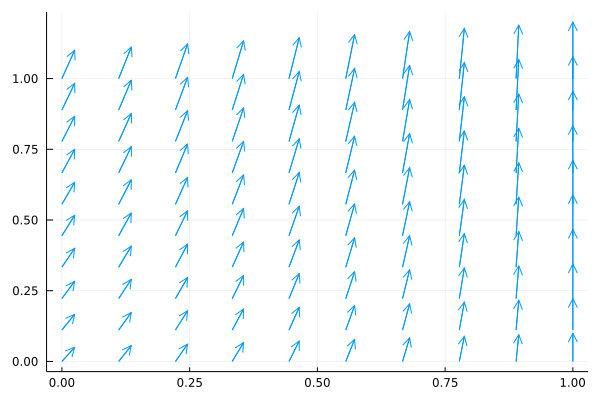

In [6]:
coord_E = [0. 0.;1. 0.;0. 1.;1. 1.]
L, VL = ConstraintMat(coord_E, "QR")

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
n = 10
xhat, yhat = meshgrid(LinRange(0,1,n), LinRange(0,1,n))
N = GetACNodalBasis(coord_E, xhat, yhat, VL)
# which N you want to plot
base = 8
u = N[1:n*n,base]
v = N[n*n+1:2*n*n,base]
scale = 0.2
quiver(xhat, yhat, quiver=(scale*u, scale*v))

In [7]:
@testset "TestNodalBasisUniform" begin

    coord_E = [0. 0.;.5 0.;0. .5;.5 .5]
    L, VL = ConstraintMat(coord_E, "QR")
    nl = GetNormal(coord_E, "left")
    nr = GetNormal(coord_E, "right")
    nb = GetNormal(coord_E, "bottom")
    nt = GetNormal(coord_E, "top")
    
    err = 1e-14
    
    # check node 1
    Nhat = GetACNodalBasis(coord_E,[-1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v1.nb=1 and v5.nl=1
    @test isapprox(dot(Nhat[:,1],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 2
    Nhat = GetACNodalBasis(coord_E,[1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v2.nb=1 and v3.nr=1
    @test isapprox(dot(Nhat[:,2],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 3
    Nhat = GetACNodalBasis(coord_E,[-1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v6.nl=1 and v7.nt=1
    @test isapprox(dot(Nhat[:,6],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 4
    Nhat = GetACNodalBasis(coord_E,[1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v8.nt=1 and v4.nr=1
    @test isapprox(dot(Nhat[:,4],nr), 1.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    
end

Test Summary:         | Pass  Total
TestNodalBasisUniform |   32     32


Test.DefaultTestSet("TestNodalBasisUniform", Any[], 32, false, false)

In [8]:
@testset "TestNodalBasisNonUniform" begin

    coord_E = [0. 0.;1. 0.;.25 .5;.75 .75]
    L, VL = ConstraintMat(coord_E, "QR")
    nl = GetNormal(coord_E, "left")
    nr = GetNormal(coord_E, "right")
    nb = GetNormal(coord_E, "bottom")
    nt = GetNormal(coord_E, "top")
    
    err = 1e-14
    
    # check node 1
    Nhat = GetACNodalBasis(coord_E,[-1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v1.nb=1 and v5.nl=1
    @test isapprox(dot(Nhat[:,1],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 2
    Nhat = GetACNodalBasis(coord_E,[1], [-1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v2.nb=1 and v3.nr=1
    @test isapprox(dot(Nhat[:,2],nb), 1.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 3
    Nhat = GetACNodalBasis(coord_E,[-1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v6.nl=1 and v7.nt=1
    @test isapprox(dot(Nhat[:,6],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,4],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 0.;atol=err)
    
    # check node 4
    Nhat = GetACNodalBasis(coord_E,[1], [1], VL)
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v8.nt=1 and v4.nr=1
    @test isapprox(dot(Nhat[:,4],nr), 1.;atol=err)
    @test isapprox(dot(Nhat[:,8],nt), 1.;atol=err)
    # check other nodes
    @test isapprox(dot(Nhat[:,1],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,2],nb), 0.;atol=err)
    @test isapprox(dot(Nhat[:,3],nr), 0.;atol=err)
    @test isapprox(dot(Nhat[:,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,6],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,7],nt), 0.;atol=err)
    
end

Test Summary:            | Pass  Total
TestNodalBasisNonUniform |   32     32


Test.DefaultTestSet("TestNodalBasisNonUniform", Any[], 32, false, false)

# The following is based on AC paper we implmented previously

In [7]:
function BilinearMap2(coord_E, xhat, yhat)
    """ 
    This function maps [xhat,yhat] in Ehat=[-1,1]^2 
    to (x,y) in E.
    Written based on eq. (3.3), (3.4) of AC paper 2016
    Input:
    ------
    coord_E: coordinates of quadrilateral E .
    coord_E is 4x2 array
    coord_E = [[x1,y1],
               [x2,y2],
               [x3,y3],
               [x4,y4]] with vertices numbering
    3----4
    |    |
    1----2
    [xhat, yhat] in Ehat
    Output:
    ------
    [x;y]: mapped vector in E.
    DF_E: Jacobian matrix
    J_E: det(DF_E)
    later we transform vector vhat to v by eq. (3.4)
    v(x) = P_E(vhat)(x) = (DF_E/J_E)*vhat(xhat)
    """
    m = length(xhat)
    P = 0.25 * [(1 .- xhat).*(1 .- yhat) (1 .+ xhat).*(1 .- yhat) (1 .- xhat).*(1 .+ yhat) (1 .+ xhat).*(1 .+ yhat)]
    P_E = P * coord_E
    # x=F_E(xhat)
    X = P_E
    x = X[:, 1]
    y = X[:, 2]
    # gradient of P, 1st row = dP/dxhat, 2nd row=dP/dyhat
    # GradP_(2m x 4)
    GradP = 0.25 * [-(1 .- yhat) (1 .- yhat) -(1 .+ yhat) (1 .+ yhat);
                    -(1 .- xhat) -(1 .+ xhat) (1 .- xhat) (1 .+ xhat)]

    # JT= [[dx/dxhat, dy/dxhat],
    #      [dx/dyhat, dy/dyhat]] (2m x 2)
    JT = GradP * coord_E
    dxdxhat = JT[1:m,1]
    dydxhat = JT[1:m,2]
    dxdyhat = JT[m+1:2*m,1]
    dydyhat = JT[m+1:2*m,2]
    J_E = dxdxhat .* dydyhat .- dydxhat .* dxdyhat
    
    DF_E = [dxdxhat dxdyhat;dydxhat dydyhat]
    
    return x, y, DF_E, J_E
end


function PrimeBasis2(coord_E, xhat, yhat)

    # original supplements in AC paper
    # sigma_hat_1 = curl((1-xhat^2)*yhat)
    # sigma_hat_2 = curl((1-yhat^2)*xhat)
    sghat1 = [(1 .- xhat.^2) (2*xhat .* yhat)]
    sghat2 = [(-2*xhat .* yhat) (yhat.^2 .- 1)]

    # (x,y) are in E
    x, y, DF_E, J_E = BilinearMap2(coord_E, xhat, yhat)

    m = length(xhat)
    # we have 8 basis including sg1 and sg2
    P = zeros(2*m,8)
    P[1:m,1] = ones(m)
    P[1:m,2] = x
    P[1:m,3] = y
    P[m+1:2*m,4] = ones(m)
    P[m+1:2*m,5] = x
    P[m+1:2*m,6] = y
    for i=1:m
    P[i,7] = dot(DF_E[i,:], sghat1[i,:]) / J_E[i]
    P[i+m,7] = dot(DF_E[i+m,:], sghat1[i,:]) / J_E[i]
    end
    
    for i=1:m
    P[i,8] = dot(DF_E[i,:], sghat2[i,:]) / J_E[i]
    P[i+m,8] = dot(DF_E[i+m,:], sghat2[i,:]) / J_E[i]
    end
    
    return P
end


function GetNormal2(coord_E, xhat, yhat)
    

    x, y, DF_E, J_E = BilinearMap2(coord_E, xhat, yhat)
    
    dxdxhat = DF_E[1,1]
    dydxhat = DF_E[2,1]
    length1 = sqrt(dxdxhat*dxdxhat + dydxhat*dydxhat)

    dxdyhat = DF_E[1,2]
    dydyhat = DF_E[2,2]
    length2 = sqrt(dxdyhat*dxdyhat + dydyhat*dydyhat)

    if (xhat[1] == -1. && -1. < yhat[1] < 1.)
        # left edge, (0,0,1)x(dxdyhat,dydyhat,0)
        n = [-dydyhat; dxdyhat]/length2

    elseif (xhat[1] == 1. && -1. < yhat[1] < 1.)
        # right edge, (0,0,-1)x(dxdyhat,dydyhat,0)
        n = [dydyhat; -dxdyhat]/length2

    elseif (yhat[1] == -1. && -1. < xhat[1] < 1.)
        # bottom edge, (0,0,-1)x(dxdxhat,dydxhat,0)
        n = [dydxhat; -dxdxhat]/length1

    elseif (yhat[1] == 1. && -1. < xhat[1] < 1.)
        # top edge, (0,0,1)x(dxdxhat,dydxhat,0)
        n = [-dydxhat; dxdxhat]/length1

    else
        println("Error! Enter the Xhat=[xhat, yhat] on the edge of Ehat")
    
    end

    return n, x, y
end


function VondermondeMat2(coord_E)
    """
    Input:
    ------
    coord_E: is the coordinate of vertices of element.
    Note
    3---4
    |   |
    1---2
    Output:
    ------
    VM: the 8x8 vondermonde matrix
    """
    nl, x, y = GetNormal2(coord_E, [-1.], [0.])
    nr, x, y = GetNormal2(coord_E, [1.], [0.])
    nb, x, y = GetNormal2(coord_E, [0.], [-1.])
    nt, x, y = GetNormal2(coord_E, [0.], [1.])
    normals = [nb nb nr nr nl nl nt nt]
    node1 = [-1.;-1.]
    node2 = [1.;-1.]
    node3 = [-1.;1.]
    node4 = [1.;1.]
    nodes = [node1 node2 node2 node4 node1 node3 node3 node4]
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(8,8)

    for i=1:8
        for j=1:8
            P = PrimeBasis2(coord_E, [nodes[1,i]], [nodes[2,i]])
            VM[i,j] = dot(P[:,j],normals[:,i])
        end
    end

    return VM
end


function GetACNodalBasis2(coord_E, xhat, yhat)
    """This function returns the AC Nodal basis at point Xhat=[xhat,yhat]
    Input:
    ------
    coord_E: coordinate of element E as 4x2 array
    Xhat: is the coordinate at reference element [-1,1]^2

    Output:
    -------
    Nhat: the nodal basis computed at Xhat=[xhat,yhat]
    shape (2,8) as
    Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    local numbering is as follow 
     v7     v8
    3---------4
  v6|         |v4
    |         |
  v5|         |v3
    1---------2
     v1     v2
    """
    VM = VondermondeMat2(coord_E)
    P = PrimeBasis2(coord_E, xhat, yhat)
    invVM = inv(VM)
    Nhat = P * invVM

    return Nhat
end

GetACNodalBasis2 (generic function with 1 method)

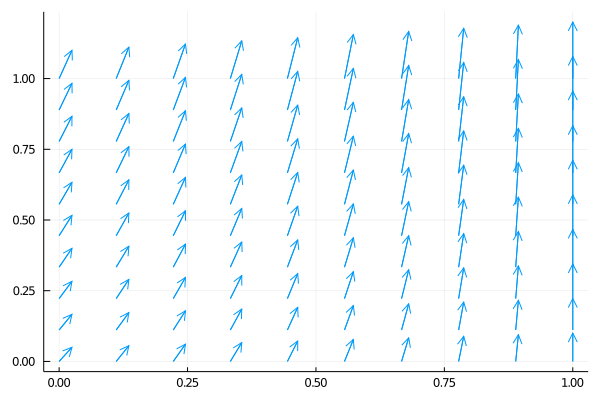

In [9]:
coord_E = [0. 0.;1. 0.;0. 1.;1. 1.]
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
n = 10
xhat, yhat = meshgrid(LinRange(0,1,n), LinRange(0,1,n))
N2 = GetACNodalBasis2(coord_E, xhat, yhat)
# which N you want to plot
base = 8
u = N2[1:n*n,base]
v = N2[n*n+1:2*n*n,base]
scale = 0.2
quiver(xhat, yhat, quiver=(scale*u, scale*v))

In [8]:
@testset "TestNodalBasisUniform" begin

    coord_E = [0. 0.;
               .5 0.;
               0. .5;
               .5 .5]
    
    nl, x, y = GetNormal2(coord_E, [-1.], [0.])
    nr, x, y = GetNormal2(coord_E, [1.], [0.])
    nb, x, y = GetNormal2(coord_E, [0.], [-1.])
    nt, x, y = GetNormal2(coord_E, [0.], [1.])
    # check node 1
    Nhat = GetACNodalBasis2(coord_E,[-1], [-1])
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v1.nb=1 and v5.nl=1
    @test dot(Nhat[:,1],nb) == 1.
    @test dot(Nhat[:,5],nl) == 1.
    # check other nodes
    @test dot(Nhat[:,2],nb) == 0.
    @test dot(Nhat[:,3],nr) == 0.
    @test dot(Nhat[:,4],nr) == 0.
    @test dot(Nhat[:,6],nl) == 0.
    @test dot(Nhat[:,7],nt) == 0.
    @test dot(Nhat[:,8],nt) == 0.

    # check node 2
    Nhat = GetACNodalBasis2(coord_E,[1], [-1])
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v2.nb=1 and v3.nr=1
    @test dot(Nhat[:,2],nb) == 1.
    @test dot(Nhat[:,3],nr) == 1.
    # check other nodes
    @test dot(Nhat[:,1],nb) == 0.
    @test dot(Nhat[:,4],nr) == 0.
    @test dot(Nhat[:,5],nl) == 0.
    @test dot(Nhat[:,6],nl) == 0.
    @test dot(Nhat[:,7],nt) == 0.
    @test dot(Nhat[:,8],nt) == 0.

    # check node 3
    Nhat = GetACNodalBasis2(coord_E,[-1], [1])
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v6.nl=1 and v7.nt=1
    @test dot(Nhat[:,6],nl) == 1.
    @test dot(Nhat[:,7],nt) == 1.
    # check other nodes
    @test dot(Nhat[:,1],nb) == 0.
    @test dot(Nhat[:,2],nb) == 0.
    @test dot(Nhat[:,3],nr) == 0.
    @test dot(Nhat[:,4],nr) == 0.
    @test dot(Nhat[:,5],nl) == 0.
    @test dot(Nhat[:,8],nt) == 0.

    # check node 4
    Nhat = GetACNodalBasis2(coord_E,[1], [1])
    # Note: Nhat = [v1,v2,v3,v4,v5,v6,v7,v8]
    # check v8.nt=1 and v4.nr=1
    @test dot(Nhat[:,4],nr) == 1.
    @test dot(Nhat[:,8],nt) == 1.
    # check other nodes
    @test dot(Nhat[:,1],nb) == 0.
    @test dot(Nhat[:,2],nb) == 0.
    @test dot(Nhat[:,3],nr) == 0.
    @test dot(Nhat[:,5],nl) == 0.
    @test dot(Nhat[:,6],nl) == 0.
    @test dot(Nhat[:,7],nt) == 0.

end


Test Summary:         | Pass  Total
TestNodalBasisUniform |   32     32


Test.DefaultTestSet("TestNodalBasisUniform", Any[], 32, false)